In [1]:
!pwd

/orfeo/cephfs/home/dssc/adellasiega/XAI_Monuments


In [10]:
import torch
from torchvision import models, transforms
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_detector(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 91 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

detector = load_detector(num_classes).to(device)

model_path = "./model/model_monumenai.pth"
detector.load_state_dict(torch.load(model_path, map_location=device))
detector.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)


image_paths = [
    "./Data/Dataset-IGRB1092_14cls/01.musulman/medina_azahara14.jpg",
    "./Data/Dataset-IGRB1092_14cls/02.gotico/torre_fadrique3.jpg",
    "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg",
    "./Data/Dataset-IGRB1092_14cls/04.barroco/convento_carmelitas_descalzas_granada6.jpg",
    "./Data/Dataset-IGRB1092_14cls/04.barroco/20181212_105011.jpg"

]

input_images = [preprocess_image(img_path).to(device) for img_path in image_paths]

with torch.no_grad():
    outputs = detector(input_images)

for idx, output in enumerate(outputs):
    print(f"Risultati per immagine {idx + 1}:")
    print("Bounding boxes:", output["boxes"])
    print("Classi:", output["labels"])
    print("Punteggi:", output["scores"])

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,


Risultati per immagine 1:
Bounding boxes: tensor([[341.1015, 219.4412, 482.6528, 372.6025],
        [212.4646, 235.5474, 331.7795, 375.5516],
        [ 98.0751, 254.8539, 203.8918, 371.2710],
        [ 49.2378,   2.2399, 523.6207, 130.4365],
        [327.1827, 121.6464, 505.1833, 228.6137],
        [328.5032, 119.4421, 499.5222, 226.1814],
        [ 89.3590, 176.5641, 222.6299, 340.5091],
        [333.9275, 120.0963, 495.2960, 247.9824],
        [ 87.7426, 166.0164, 218.0568, 266.6746],
        [ 89.5959, 168.1388, 214.4342, 257.7023],
        [207.2784, 145.2919, 329.0052, 230.9181],
        [318.3307, 141.2073, 505.4672, 363.3376],
        [205.0286, 144.9092, 330.0749, 230.6620],
        [208.4863, 144.4560, 332.5385, 252.7875],
        [ 92.1616,   4.6563, 524.0582, 127.9159],
        [128.4171, 238.9222, 353.2628, 391.1632]], device='cuda:0')
Classi: tensor([1, 1, 1, 7, 4, 5, 1, 1, 4, 5, 5, 1, 4, 1, 5, 1], device='cuda:0')
Punteggi: tensor([0.9983, 0.9964, 0.9885, 0.8321, 0.6814, 

In [9]:
def extract_features(detector, input_images):
    """
    Estrae feature numeriche dalle immagini originali usando il backbone del detector.
    """
    detector.eval()
    with torch.no_grad():
        # Ottieni i risultati del detector
        outputs = detector(input_images)

        # Lista per salvare le feature estratte
        features_list = []

        # Itera sulle immagini
        for idx, output in enumerate(outputs):
            boxes = output["boxes"]
            labels = output["labels"]
            scores = output["scores"]

            # Usa solo le regioni con punteggi sufficientemente alti
            high_score_indices = scores > 0.5
            filtered_boxes = boxes[high_score_indices]
            filtered_labels = labels[high_score_indices]

            # Calcola una rappresentazione numerica per ogni box
            # Qui potresti aggiungere un estrattore di feature specifico
            # Per esempio, media dei valori pixel, oppure usare il backbone del detector
            features = []
            for box in filtered_boxes:
                cropped_image = input_images[idx][:, int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                # Calcola qualche statistica o passa il crop in un modello
                features.append(cropped_image.mean().item())  # Dummy: usa feature più significative

            features_list.append(features)

        return features_list
# Prepara le feature per il classificatore
features = extract_features(detector, input_images)

# Assumi che ogni immagine produca un array di dimensioni compatibili con il classificatore
# Puoi usare padding o altre tecniche per uniformare la lunghezza
prepared_features = np.zeros((len(features), 17))  # Supponendo che il classificatore si aspetti 17 feature
for i, feat in enumerate(features):
    prepared_features[i, :len(feat)] = feat[:17]  # Trunca o pad per uniformare

# Passa le feature al classificatore
classificator = load_model("./model/classificator.keras")
predicted_probabilities = classificator.predict(prepared_features)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
for i, pred_class in enumerate(predicted_classes):
    print(f"Immagine {i + 1}: Stile predetto: {styles_map[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Immagine 1: Stile predetto: Hispanic-muslim
Immagine 2: Stile predetto: Renaissance
Immagine 3: Stile predetto: Renaissance
Immagine 4: Stile predetto: Hispanic-muslim
Immagine 5: Stile predetto: Hispanic-muslim


In [11]:
def predict_style_with_explanations(detector, classificator, image_path, threshold=0.5, styles_map=None):
    # Preprocessa l'immagine
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(next(detector.parameters()).device)

    # Ottieni i risultati del detector
    detector.eval()
    with torch.no_grad():
        outputs = detector(input_image)

    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]
    labels = outputs[0]["labels"]

    # Filtra le bounding box con punteggio sopra il threshold
    high_score_indices = scores > threshold
    filtered_boxes = boxes[high_score_indices]
    filtered_scores = scores[high_score_indices]
    filtered_labels = labels[high_score_indices]

    # Prepara le feature basandoti sui riquadri selezionati
    features = []
    for box in filtered_boxes:
        x_min, y_min, x_max, y_max = box.int().cpu().numpy()
        cropped_image = input_image[0, :, y_min:y_max, x_min:x_max]
        feature = cropped_image.mean().item()  # Dummy: sostituire con feature più significative
        features.append(feature)

    # Pad/Tronca le feature per adattarle al classificatore
    max_features = classificator.input_shape[-1]  # Supponendo input_shape di Keras
    prepared_features = np.zeros((1, max_features))
    prepared_features[0, :len(features)] = features[:max_features]

    # Predici lo stile
    predicted_probabilities = classificator.predict(prepared_features)
    predicted_class = np.argmax(predicted_probabilities, axis=1)[0]
    predicted_style = styles_map[predicted_class] if styles_map else predicted_class

    # SHAP per interpretare
    explainer = shap.KernelExplainer(classificator.predict, prepared_features)
    shap_values = explainer.shap_values(prepared_features, nsamples=30)

    return image, filtered_boxes.cpu().numpy(), shap_values, predicted_style


In [101]:
def visualize_explanations(image, boxes, shap_values, predicted_style, styles_map=None):
    shap_scores = np.array([abs(val) for val in shap_values[0][0]])  # Assumi SHAP per la prima classe
    
    # Gestisci mismatch tra SHAP e riquadri
    if len(shap_scores) < len(boxes):
        print("Avviso: meno valori SHAP rispetto ai riquadri. Riempiendo con zero.")
        shap_scores = np.pad(shap_scores, (0, len(boxes) - len(shap_scores)), constant_values=0)
    
    elif len(shap_scores) > len(boxes):
        print("Avviso: più valori SHAP rispetto ai riquadri. Troncando.")
        shap_scores = shap_scores[:len(boxes)]
        
    # Mostra immagine con riquadri
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Sovrapponi i riquadri
    shap_scores = shap_scores / shap_scores.max()  # Normalizza
    for i, box in enumerate(boxes):
        print(box)
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=5, edgecolor=plt.cm.Reds(0.7), facecolor='none')
        ax.add_patch(rect)
        


    # Predizione
    title = f"Predizione dello stile: {predicted_style}"
    ax.set_title(title, fontsize=16)
    plt.axis("off")
    plt.show()

In [102]:
styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
image_path = "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg"

image, boxes, shap_values, predicted_style = predict_style_with_explanations(
    detector, classificator, image_path, threshold=0.5, styles_map=styles_map
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


Avviso: meno valori SHAP rispetto ai riquadri. Riempiendo con zero.
[141.22325 335.69867 350.35867 606.7872 ]
[ 106.00016  984.2841   304.7606  1216.6267 ]
[ 601.1331   920.90796  996.1165  1431.4594 ]
[1258.7739   337.85547 1449.1876   624.03595]
[1273.6018  971.1735 1507.6312 1266.6953]
[ 514.6932   744.7336  1057.1505   917.63275]
[ 508.23608    86.044525 1066.4812    549.4723  ]
[  0.      327.09973  54.25603 594.6798 ]
[152.73108 752.09625 290.20422 897.16797]
[197.78532  93.24089 333.63702 228.01303]
[1284.688    100.46957 1419.2894   246.66364]
[181.48485   94.050934 334.31375  215.80663 ]
[  0.66668046 334.05313     20.270025   591.96826   ]
[  0.        73.392395  54.8484   247.07678 ]
[ 519.0601   741.87616 1063.1506   933.7752 ]
[1508.4658  748.5558 1600.     1378.2777]
[1320.5831  760.1099 1462.1238  902.4641]
[ 486.14203  101.77002 1097.252    565.8597 ]


/tmp/ipykernel_1695443/772916887.py:18: RuntimeWarning: invalid value encountered in divide
  shap_scores = shap_scores / shap_scores.max()  # Normalizza


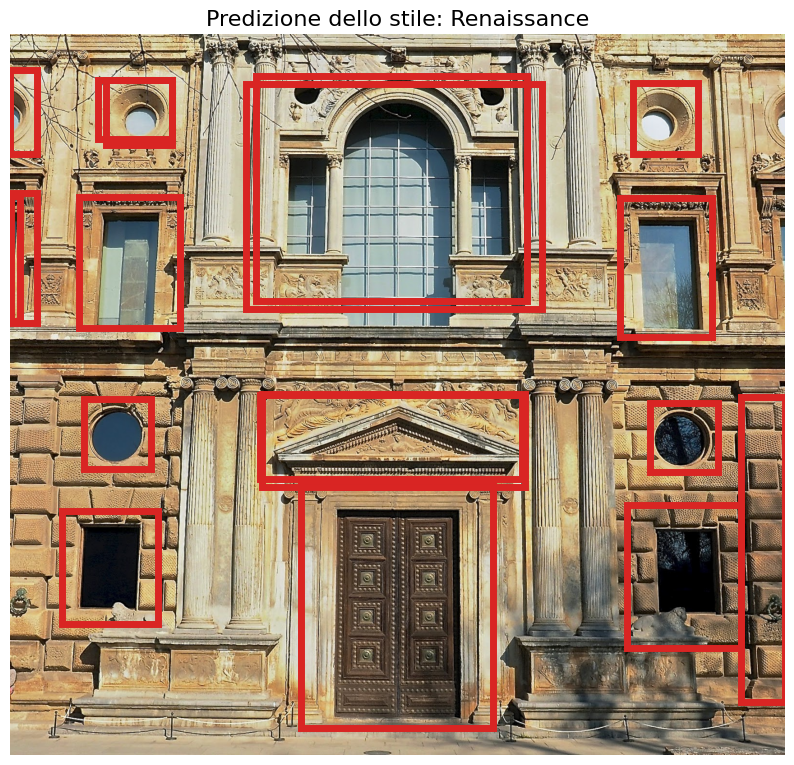

In [103]:
visualize_explanations(image, boxes, shap_values, predicted_style, styles_map=styles_map)